In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error

res_dir = Path('/bsuhome/zacharykeskinen/spicy-snow/results/site_param_rmses/')

In [166]:
dfs = {}
for res in res_dir.glob('*.csv'):
    df = pd.read_csv(res, index_col = 0)
    dfs[res.stem] = df

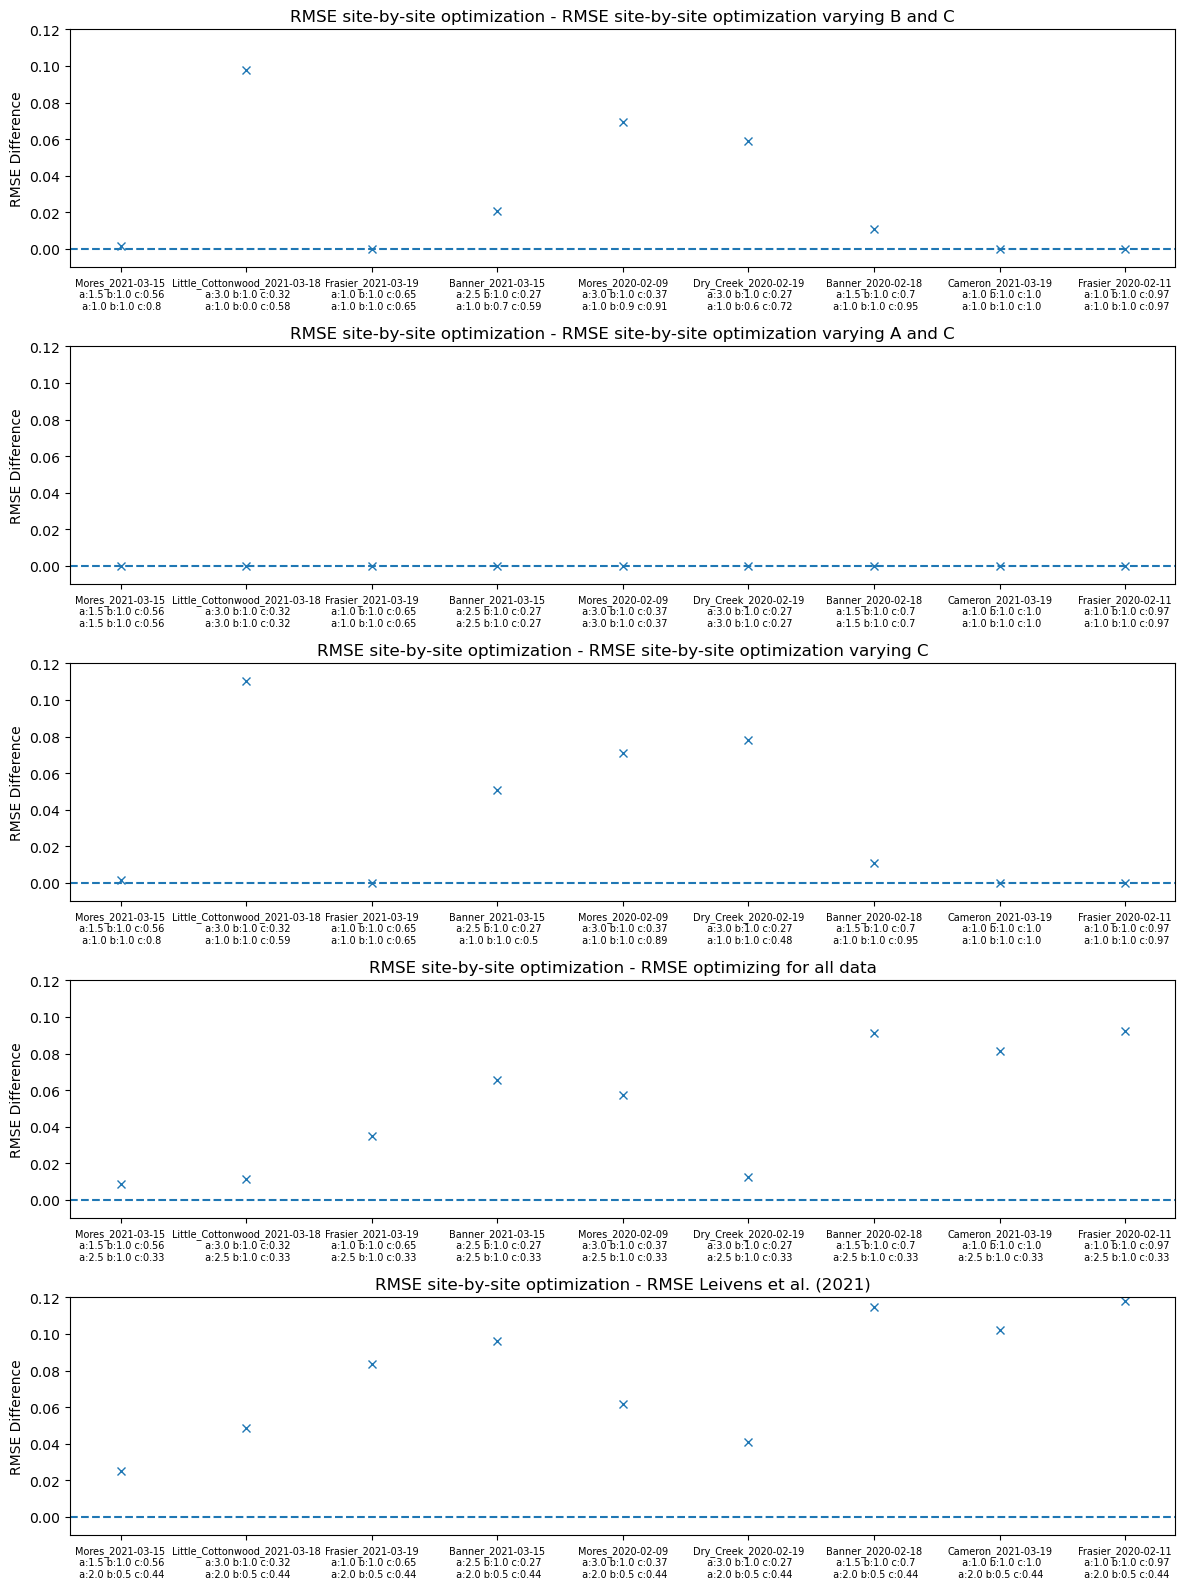

In [173]:
fig, axes = plt.subplots(5, 1, figsize = (12, 16))

for i, (col1, col2) in enumerate([['varying_all', 'varying_b_c'], ['varying_all', 'varying_a_c'], ['varying_all', 'varying_c'], ['varying_all', 'all_sites'], ['varying_all','leivens_params']]):
    diff = dfs[col2]['rmse'] - dfs[col1]['rmse']
    param_index = dfs['varying_all'].index + '\n a:' +dfs[col1].a.astype(str) + ' b:' +dfs[col1].b.astype(str) + ' c:' +dfs[col1].c.astype(str) + '\n' + ' a:' +dfs[col2].a.astype(str) + ' b:' +dfs[col2].b.astype(str) + ' c:' +dfs[col2].c.astype(str)
    diff = diff.set_axis(param_index.values)
    diff.plot(linestyle = 'None', marker = 'x', ax = axes[i])

axes[0].set_title('RMSE site-by-site optimization - RMSE site-by-site optimization varying B and C')
axes[1].set_title('RMSE site-by-site optimization - RMSE site-by-site optimization varying A and C')
axes[2].set_title('RMSE site-by-site optimization - RMSE site-by-site optimization varying C')
axes[3].set_title('RMSE site-by-site optimization - RMSE optimizing for all data')
axes[4].set_title('RMSE site-by-site optimization - RMSE Leivens et al. (2021)')

for ax in axes:
    ax.set_ylabel('RMSE Difference')
    ax.set_ylim(-0.01, 0.12)
    ax.tick_params(axis='x', labelrotation = 0, labelsize = 7)
    ax.axhline(0, linestyle = 'dashed')

plt.tight_layout()
plt.savefig('/bsuhome/zacharykeskinen/spicy-snow/images/site_specific_params/optimization_rmse_compare.png')